In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sn
from torchsummary import summary


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [23]:
DATA_TRAIN_PATH = "MP_Data_Train"
VIDEO_TRAIN_PATH = "MP_Video_Train"
actions = np.array(["aw", "ee", "ow", "sac", "hoi", "nang", "nothing", "aa", "oo", "uw", "nga", "huyen"])
no_sequences_train = 170
sequence_length = 30
batch_size = 32
max_epoch = 125
LR = 0.0005
input_size = 63
hidden_size1 = 256
hidden_size2 = 128
num_classes = len(actions)
PREDICTION_THRESHOLD = 0.5

In [24]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [25]:
#Xử lý dữ liệu
label_map = {label: num for num, label in enumerate(actions)} #ánh xạ các label thành số aa: 0, aw: 1,....
sequences_train, labels_train = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_TRAIN_PATH, action))).astype(int):
        window = [np.load(os.path.join(DATA_TRAIN_PATH, action, str(sequence), f"{frame_num}.npy")) for frame_num in range(sequence_length)]#(30, 63)
        # window là 1 list chứa 30 npy array keypoints của 1 action của 1 sequence mỗi seq là 63 giá trị
        sequences_train.append(window)# 170 window
        labels_train.append(label_map[action])# gán label

X = torch.tensor(np.array(sequences_train), dtype=torch.float32)
Y = torch.tensor(np.array(labels_train), dtype=torch.long)

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=6/17, random_state=42, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2/11, random_state=42, stratify=y_train)

# Tạo datasets và dataloader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f'Data: {no_sequences_train*len(actions)}')
print(f'Train len: {len(train_dataset)}')
print(f'Validation len: {len(val_dataset)}')
print(f'Test len: {len(test_dataset)}')

Data: 2040
Train len: 1080
Validation len: 240
Test len: 720


In [26]:
class GRUCell(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.R = nn.Linear(in_dim + out_dim, out_dim)

        self.Z = nn.Linear(in_dim + out_dim, out_dim)
        
        self.H = nn.Linear(in_dim + out_dim, out_dim)

    def forward(self, inputs, hidden_state):
        xh = torch.cat((inputs, hidden_state), dim=-1)
        R = torch.sigmoid(self.R(xh))
        Z = torch.sigmoid(self.Z(xh))
        xrh = torch.cat((inputs, R * hidden_state), dim=-1)
        HC = torch.tanh(self.H(xrh))
        ht = Z * hidden_state + (1 - Z) * HC
        return ht

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, sequence_length):
        super(GRUModel, self).__init__()
        self.gru1 = GRUCell(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(p=0.2)
        self.gru2 = GRUCell(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_size2 * sequence_length, num_classes)

    def forward(self, x):
        hidden_state1 = torch.zeros(x.size(0), self.gru1.out_dim).to(x.device)
        hidden_state2 = torch.zeros(x.size(0), self.gru2.out_dim).to(x.device)
        
        gru_outputs = []
        for t in range(x.size(1)):
            hidden_state1 = self.gru1(x[:, t, :], hidden_state1)
            hidden_state1 = self.dropout1(hidden_state1)
            hidden_state2 = self.gru2(hidden_state1, hidden_state2)
            hidden_state2 = self.dropout2(hidden_state2)
            gru_outputs.append(hidden_state2)

        out = torch.stack(gru_outputs, dim=1)
        out = out.reshape(out.size(0), -1)
        return self.fc(out)

model = GRUModel(input_size, hidden_size1, hidden_size2, num_classes, sequence_length).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#torch.manual_seed(1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          81,920
            Linear-2                  [-1, 256]          81,920
            Linear-3                  [-1, 256]          81,920
           GRUCell-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          49,280
            Linear-7                  [-1, 128]          49,280
            Linear-8                  [-1, 128]          49,280
           GRUCell-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                  [-1, 256]          81,920
           Linear-12                  [-1, 256]          81,920
           Linear-13                  [-1, 256]          81,920
          GRUCell-14                  [

In [28]:
def evaluate(model, loader, criterion, device, class_names=None, plot_cm=False):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    if plot_cm:
        # Tính confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Nếu không có class_names, dùng số từ 0 đến n-1
        if class_names is None:
            class_names = [str(i) for i in range(len(np.unique(all_labels)))]
        
        # Vẽ confusion matrix
        plt.figure(figsize=(12, 10))
        sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix for Test Set Predictions')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    
    return test_loss / len(loader), accuracy, precision, recall, f1

In [29]:
#trainning loop
train_losses, train_accuracies, train_precisions, train_recalls, train_f1s = [], [], [], [], []
val_losses, val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], [], []

for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        loss.backward()
        optimizer.step()
 
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * running_correct / total
    epoch_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    epoch_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
 
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate(model, val_loader, criterion, device)
    
    print(f"Epoch [{epoch + 1}/{max_epoch}], "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, ")
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    train_precisions.append(epoch_precision)
    train_recalls.append(epoch_recall)
    train_f1s.append(epoch_f1)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

Epoch [1/125], Val Loss: 2.0582, Val Accuracy: 36.25%, 
Epoch [2/125], Val Loss: 1.2165, Val Accuracy: 65.00%, 
Epoch [3/125], Val Loss: 0.6624, Val Accuracy: 80.42%, 
Epoch [4/125], Val Loss: 0.4456, Val Accuracy: 85.42%, 
Epoch [5/125], Val Loss: 0.3036, Val Accuracy: 91.67%, 
Epoch [6/125], Val Loss: 0.2608, Val Accuracy: 91.67%, 
Epoch [7/125], Val Loss: 0.2039, Val Accuracy: 95.00%, 
Epoch [8/125], Val Loss: 0.1665, Val Accuracy: 96.67%, 
Epoch [9/125], Val Loss: 0.1503, Val Accuracy: 94.17%, 
Epoch [10/125], Val Loss: 0.1132, Val Accuracy: 96.67%, 
Epoch [11/125], Val Loss: 0.1287, Val Accuracy: 95.00%, 
Epoch [12/125], Val Loss: 0.1243, Val Accuracy: 95.00%, 
Epoch [13/125], Val Loss: 0.3774, Val Accuracy: 82.92%, 
Epoch [14/125], Val Loss: 0.1004, Val Accuracy: 97.08%, 
Epoch [15/125], Val Loss: 0.0845, Val Accuracy: 97.08%, 
Epoch [16/125], Val Loss: 0.0822, Val Accuracy: 97.08%, 
Epoch [17/125], Val Loss: 0.0704, Val Accuracy: 97.92%, 
Epoch [18/125], Val Loss: 0.1174, Val Ac

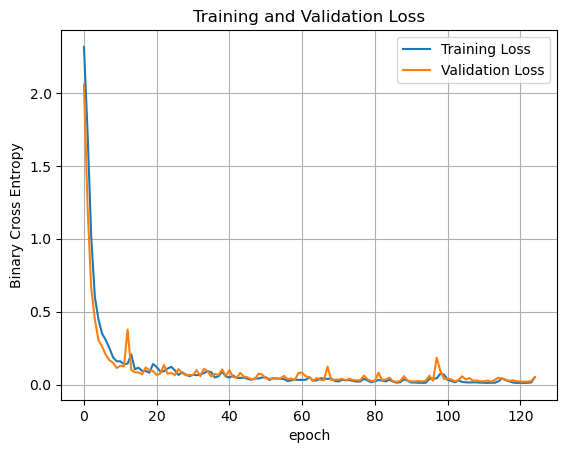

In [30]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

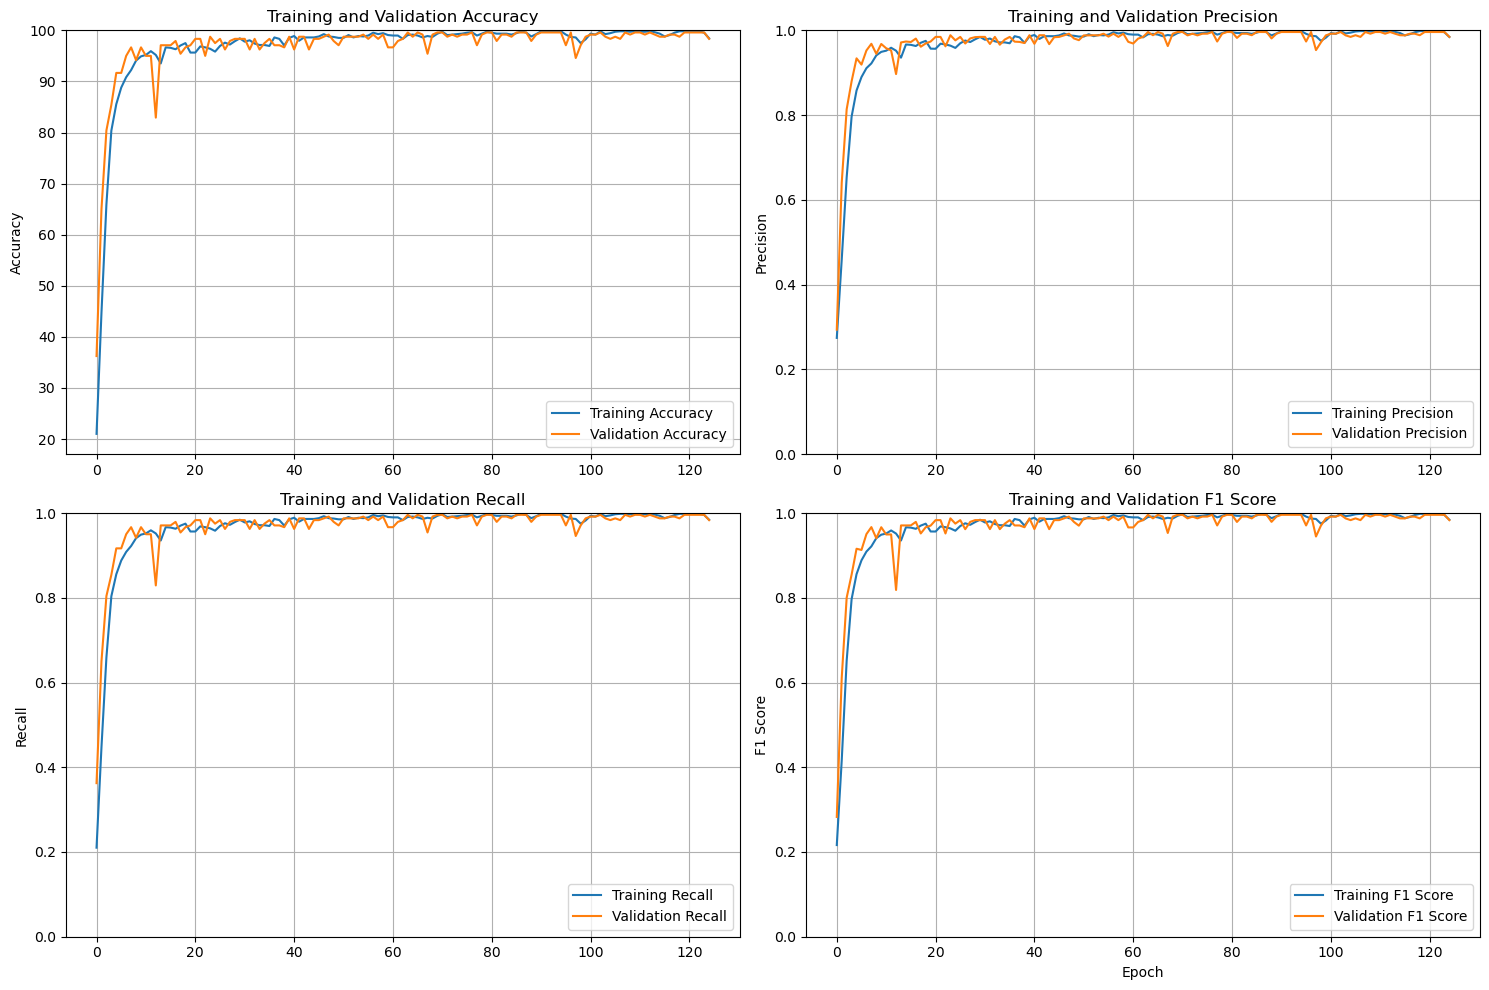

In [31]:
# Vẽ biểu đồ
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 100])
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Biểu đồ Precision
plt.subplot(2, 2, 2)
plt.plot(train_precisions, label='Training Precision')
plt.plot(val_precisions, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.title('Training and Validation Precision')
plt.grid(True)

# Biểu đồ Recall
plt.subplot(2, 2, 3)
plt.plot(train_recalls, label='Training Recall')
plt.plot(val_recalls, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([0, 1])
plt.title('Training and Validation Recall')
plt.grid(True)

# Biểu đồ F1 Score
plt.subplot(2, 2, 4)
plt.plot(train_f1s, label='Training F1 Score')
plt.plot(val_f1s, label='Validation F1 Score')
plt.legend(loc='lower right')
plt.ylabel('F1 Score')
plt.ylim([0, 1])
plt.title('Training and Validation F1 Score')
plt.grid(True)

plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

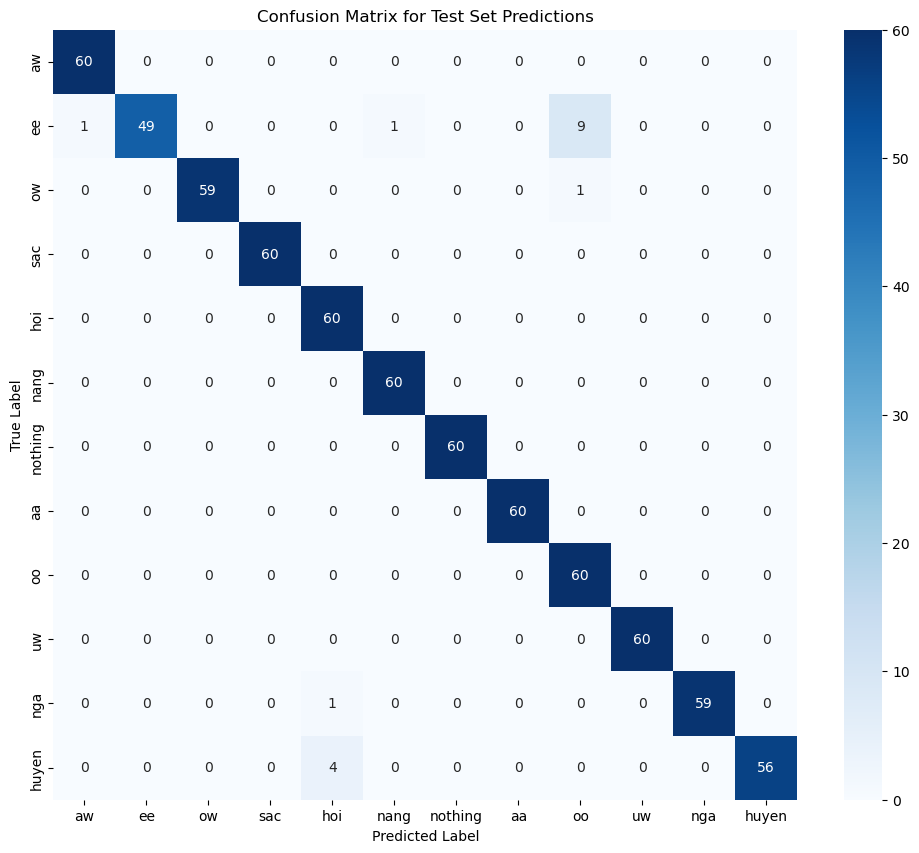

Test Loss: 0.0582, Test Accuracy: 97.64%, Test Precision: 0.9790, Test Recall: 0.9764, Test F1: 0.9762


In [32]:
    # Sau vòng lặp huấn luyện, thêm đoạn code này để đánh giá tập test và in confusion matrix
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(
    model, test_loader, criterion, device, class_names=actions, plot_cm=True
)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, "
      f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")